In [1]:
from matplotlib import pylab as plt
from Gridworld import Gridworld
import tensorflow as tf
import random
import numpy as np
import keras
from collections import deque
from tensorflow.keras import(
    layers,
    models,
    metrics,
    losses,
    optimizers,
)

2025-03-11 08:29:25.492867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 08:29:25.632606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-11 08:29:25.632630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-11 08:29:25.666749: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 08:29:26.378163: W tensorflow/stream_executor/platform/de

In [2]:
# Custom neural network layer designed for a grid game agent.
# Inherits from Keras' Layer class, allowing integration within the Keras framework.
class model(keras.Model):
    def __init__(self):
        # Initialize the parent Layer to ensure proper setup of the underlying mechanisms.
        super().__init__()

        # Define the first dense layer with 150 units.
        self.layer1 = keras.layers.Dense(150, use_bias=False, name='layer1')
        # Define the second dense layer with 100 units.
        self.layer2 = keras.layers.Dense(100, use_bias=True, name='layer2')
        # Define the third dense (output) layer with 4 units (4 because there are 4 possible actions in the game)
        self.layer3 = keras.layers.Dense(4, use_bias=True, name='layer3')

    def call(self, inputs):
        # Forward propagation through the network begins with the first dense layer.
        x = self.layer1(inputs)
        # Apply the ReLU activation function to introduce non-linearity.
        x = tf.nn.relu(x)
        # Pass the output through the second dense layer.
        x = self.layer2(x)
        # Again, apply the ReLU activation function to capture non-linear relationships.
        x = tf.nn.relu(x)

        # Process the data through the final dense layer to produce the network output.
        # Note: No activation function is applied after this layer. This is often
        # intentional in reinforcement learning setups, where raw scores (logits)
        # may be used directly or processed with a softmax/cross-entropy loss externally.
        x = self.layer3(x)
        
        # Return the final computed output.
        return x

# Note:
# The input dimensions for this model are inferred at runtime when the model is first called.
# This dynamic input size handling is a feature of Keras that promotes flexibility in designing models.

In [3]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [14]:
# create an instance of the model while additionally defining loss and optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError()
Qnetwork = model()
Targetnetwork = model()

In [15]:
# Initialize a counter to track the number of training iterations (loops/epochs)
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
epochs = 4500
#TensorArray being expandable while runtime
loss_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
move_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
win_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
loop_cnt = 0
#syncronize target and q network
j=0
sync_freq = 300

gamma = 0.9
epsilon = 0.3

# Loop over the specified number of epochs
for i in range(epochs):  # B: Iterate through each training epoch
    print('epoch= ', i)
    loop_cnt += 1  # Increment the loop counter for each epoch

    # Initialize a new Gridworld game with a 4x4 grid and a static configuration
    game = Gridworld(size=4, mode='random')  # C

    # Render the game board as a NumPy array, reshape it to a 1x64 vector,
    # and add a small amount of random noise to slightly perturb the state.
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0  # D

    # Convert the NumPy state representation to a TensorFlow tensor for model input
    state1 = tf.convert_to_tensor(state_)
    
    # Set a status flag to indicate that the game is ongoing
    status = 1  # F

    # Initialize counters for moves within the current game and to accumulate loss
    mov = 0
    loss_tmp = 0


    # Continue playing until the game signals termination (status != 1)
    while status == 1:  # G
        mov += 1  # Increment the move counter
        j+=1 #increase syncronizing counter with target network
        #print(f"move: {mov}")

        # Obtain Q-values by forwarding the current state through the agent's network
        qval = Qnetwork(state1)  # H

        # Convert the Q-values tensor to a NumPy array (note: this conversion might reduce performance)
        qval_ = qval.numpy()

        # Epsilon-greedy action selection: with probability epsilon, choose a random action for exploration,
        # otherwise choose the action with the highest Q-value
        if random.random() < epsilon:  # I
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        # Map the selected action index to the corresponding action in the predefined action set
        action = action_set[action_]  # J

        # Apply the selected action to the game environment
        game.makeMove(action)  # K

        # Render the updated game state, reshape, and add noise as before
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = tf.convert_to_tensor(state2_)

        # Obtain the reward from the environment after the action
        reward_ = game.reward()

        # Convert the reward to a TensorFlow tensor and cast it to float
        reward = tf.convert_to_tensor(reward_)
        reward = tf.cast(reward, float)

        # Determine if the episode is complete. Here, a positive reward signifies the end of an episode.
        done = True if reward_ > 0 else False

        # Package the experience tuple (current state, action taken, reward, next state, done flag)
        exp = (state1, action_, reward, state2, done)  # G

        # Append the experience tuple to the replay memory for future training
        replay.append(exp)  # H

        # Update the current state to the new state
        state1 = state2

        # Once enough experiences are collected, sample a minibatch for training at each cycle
        if len(replay) > batch_size:  # I
            #print('optimize')
            # Randomly sample a minibatch from the replay memory
            minibatch = random.sample(replay, batch_size)  # J

            # Extract batches of states, actions, rewards, next states, and done flags from the minibatch
            state1_batch = tf.convert_to_tensor([s1 for (s1, a, r, s2, d) in minibatch])  # K
            action_batch = tf.convert_to_tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = tf.convert_to_tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = tf.convert_to_tensor([s2 for (s1, a, r, s2, d) in minibatch])
            # The done flag is kept as a list for further arithmetic operations
            done_batch = [d for (s1, a, r, s2, d) in minibatch]

            #print('batchsize: ', batch_size)

            # Begin recording gradients for backpropagation
            # together tape.gradient later, only within this section backpropagation is carried out
            with tf.GradientTape() as tape:
                # Compute Q-values for the batch of current states
                Q1 = Qnetwork(state1_batch)    # Expected shape: [batch_size, 1, 4]
                Q1 = tf.squeeze(Q1)         # Reshape to: [batch_size, 4]

                # For each predicted q vector, select the q value for the stored action
                X = [row[index] for row, index in zip(Q1, action_batch)]
                X = tf.convert_to_tensor(X)

                # Compute target Q-values without tracking gradients for the stored second steps
                with tape.stop_recording():
                    # Forward pass for the batch of next states
                    Q2 = Targetnetwork(state2_batch)
                    Q2 = tf.squeeze(Q2)
                    I = tf.ones((1, batch_size))
                    # Compute the target Q-value using the Bellman equation:
                    # in the second step no action is stored. The maximum Q value is chosen
                    Y = reward_batch + gamma * ((I - done_batch) * tf.reduce_max(Q2, axis=1))

                # Calculate the loss between predicted Q-values and target Q-values
                loss = loss_fn([X], [Y])  # P
                #print('loss= ', loss)
                loss_tmp = loss_tmp + loss.numpy()

                # Compute gradients of the loss with respect to the agent's trainable weights
                grads = tape.gradient(loss, Qnetwork.trainable_weights)
                # Apply the computed gradients to update the agent's weights (currently commented out)
                optimizer.apply_gradients(zip(grads, Qnetwork.trainable_weights))


                #synchronize target network
                if j % sync_freq == 0:
                    Targetnetwork.set_weights(Qnetwork.get_weights())


    # After exiting the inner loop, check termination conditions:
    # If a terminal reward is received (reward != -1) or the move count exceeds max_moves, end the game.
    
        if reward != -1 or mov > max_moves:  # O
            print(f"mov: {mov}")
            status = 0
            if reward == 10:
                win_list = win_list.write(loop_cnt,1)
            else:
                win_list = win_list.write(loop_cnt,0)


    # Record the cumulative loss for this epoch into loss_list
    loss_list = loss_list.write(loop_cnt, loss_tmp)
    move_list = move_list.write(loop_cnt,mov)
    print(f"loss: {loss_tmp}")

epoch=  0
mov: 12
loss: 0
epoch=  1
mov: 46
loss: 0
epoch=  2
mov: 51
loss: 0
epoch=  3
mov: 18
loss: 0
epoch=  4
mov: 19
loss: 0
epoch=  5
mov: 51
loss: 0
epoch=  6
mov: 6
loss: 8.637690305709839
epoch=  7
mov: 1
loss: 3.6764981746673584
epoch=  8
mov: 1
loss: 4.143600940704346
epoch=  9
mov: 51
loss: 186.78961157798767
epoch=  10
mov: 5
loss: 14.246859550476074
epoch=  11
mov: 51
loss: 176.15009903907776
epoch=  12
mov: 1
loss: 4.357640743255615
epoch=  13
mov: 51
loss: 181.83044850826263
epoch=  14
mov: 4
loss: 13.199244022369385
epoch=  15
mov: 11
loss: 34.59852147102356
epoch=  16
mov: 51
loss: 168.82456612586975
epoch=  17
mov: 4
loss: 10.050082445144653
epoch=  18
mov: 51
loss: 158.92283380031586
epoch=  19
mov: 51
loss: 140.68506681919098
epoch=  20
mov: 17
loss: 47.68142211437225
epoch=  21
mov: 1
loss: 4.401273727416992
epoch=  22
mov: 3
loss: 5.560065746307373
epoch=  23
mov: 35
loss: 92.05810970067978
epoch=  24
mov: 18
loss: 61.50114893913269
epoch=  25
mov: 18
loss: 65.76

In [16]:
#store weights:
Qnetwork.save_weights("Qnetwork_weights_Targetnetwork.weights.h5")  # Saves weights in HDF5 format
Targetnetwork.save_weights("Targetnetwork_weights_Targetnetwork.weights.h5")  # Saves weights in HDF5 format

In [17]:
#saving the list
import json
loss_Targetnetwork = loss_list.stack().numpy().tolist()
with open("loss_Targetnetwork.json","w") as f:
    json.dump(loss_Targetnetwork,f)

move_Targetnetwork = move_list.stack().numpy().tolist()
with open("move_Targetnetwork.json","w") as f:
    json.dump(move_Targetnetwork,f)

win_Targetnetwork = win_list.stack().numpy().tolist()
with open("win_Targetnetwork.json","w") as f:
    json.dump(win_Targetnetwork,f)

In [11]:
with open("win_Targetnetwork.json","r") as f:
    win = json.load(f)

print(win)

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,

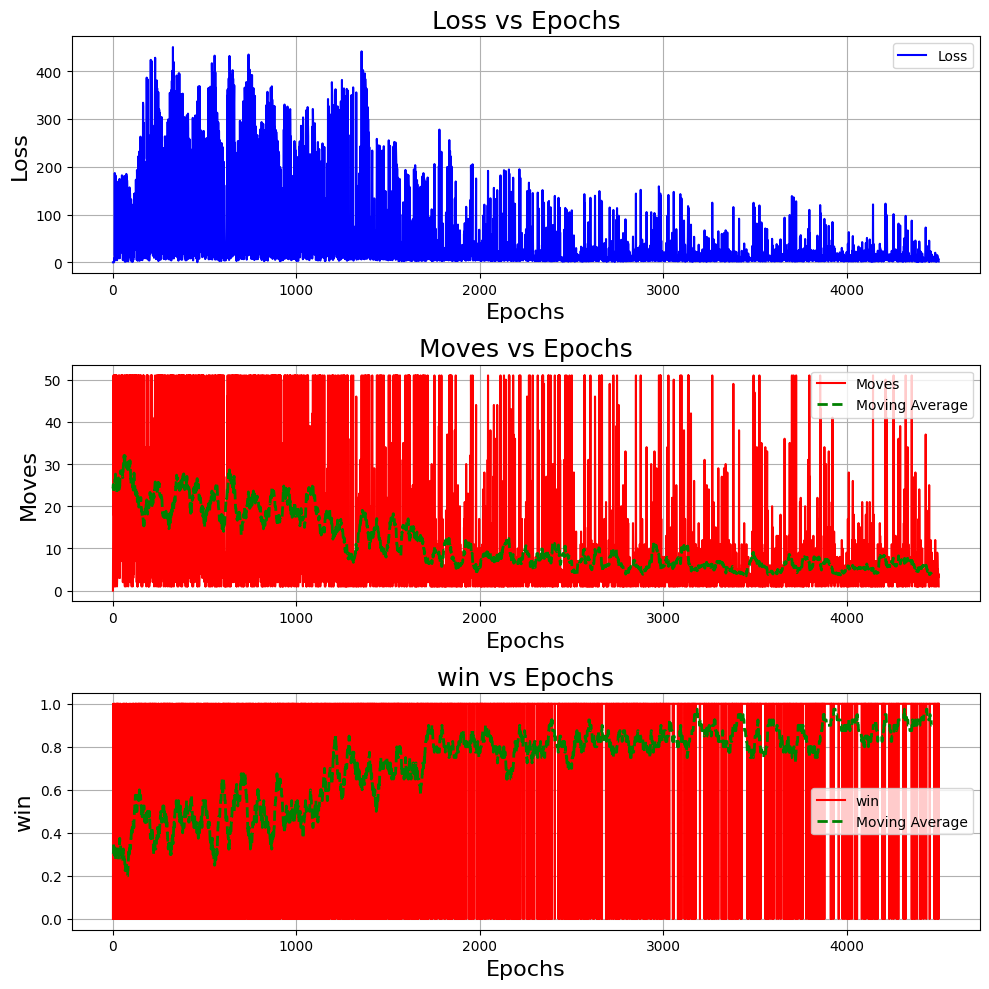

In [18]:
with open("loss_Targetnetwork.json","r") as f:
    loss2 = json.load(f)
with open("move_Targetnetwork.json","r") as f:
    moves = json.load(f)
with open("win_Targetnetwork.json","r") as f:
    win = json.load(f)

# ✅ Ensure moves is a NumPy array
moves = np.array(moves)

# ✅ Define epochs dynamically based on length of moves
epochs = np.arange(len(moves))  # Creates an array [0, 1, 2, ..., len(moves)-1]
# ✅ Compute Moving Average (SMA with window size = 3)
window_size = 40  # Adjust to control smoothness
moving_avg = np.convolve(moves, np.ones(window_size) / window_size, mode='valid')
moving_avg_win = np.convolve(win, np.ones(window_size) / window_size, mode='valid')

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))  # Two rows, one column

# ✅ First subplot: Loss over epochs
axes[0].plot(loss2, color='b', label="Loss")
axes[0].set_xlabel("Epochs", fontsize=16)
axes[0].set_ylabel("Loss", fontsize=16)
axes[0].set_title("Loss vs Epochs", fontsize=18)
axes[0].legend()
axes[0].grid(True)

# ✅ Second subplot: Moves over epochs
axes[1].plot(moves, color='r', label="Moves")
axes[1].plot(epochs[:len(moving_avg)], moving_avg, color='g', linestyle='dashed', linewidth=2, label="Moving Average")  # Moving average curve
axes[1].set_xlabel("Epochs", fontsize=16)
axes[1].set_ylabel("Moves", fontsize=16)
axes[1].set_title("Moves vs Epochs", fontsize=18)
axes[1].legend()
axes[1].grid(True)


# ✅ Third subplot: Moves over epochs
axes[2].plot(win, color='r', label="win")
axes[2].plot(epochs[:len(moving_avg_win)], moving_avg_win, color='g', linestyle='dashed', linewidth=2, label="Moving Average")  # Moving average curve
axes[2].set_xlabel("Epochs", fontsize=16)
axes[2].set_ylabel("win", fontsize=16)
axes[2].set_title("win vs Epochs", fontsize=18)
axes[2].legend()
axes[2].grid(True)


# Adjust layout for better spacing
plt.tight_layout()
plt.show()